In [1]:
import sys

sys.path.append("../..")
import numpy as np
import tensorflow as tf
from Bio import SeqIO

import tensortree

2025-10-10 14:20:30.738196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760098830.755727 3444203 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760098830.761214 3444203 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760098830.775686 3444203 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760098830.775712 3444203 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760098830.775714 3444203 computation_placer.cc:177] computation placer alr

In [2]:
msa_file = "seq-gen.out"
tree_file = "RAxML_bestTree.out2"
alphabet = "ACGT"

In [3]:
tensortree.set_backend("tensorflow")

In [4]:
# parse fasta
leaf_names = []
seqs = []
for record in SeqIO.parse(msa_file, "fasta"):
    leaf_names.append(record.id)
    seqs.append(str(record.seq))

one_hot_leaves = tensortree.util.encode_one_hot(seqs, alphabet=alphabet)
one_hot_leaves = one_hot_leaves[:, np.newaxis] # add model dimension

# create tree
tree = tensortree.TreeHandler.read(tree_file)

In [5]:
def inverse_softplus(x):
    return np.log(np.exp(x) - 1 + 1e-16)

# create variables, trivially initialize
R, pi = tensortree.substitution_models.jukes_cantor(d = len(alphabet))
R_kernel = tf.Variable(inverse_softplus(R))
pi_kernel = tf.Variable(np.log(pi))
B_kernel = tf.Variable(inverse_softplus(np.ones_like(tree.branch_lengths)))


def make_R_pi_B(R_kernel, pi_kernel, B_kernel):
    R = tensortree.model.backend.make_symmetric_pos_semidefinite(R_kernel)
    pi = tensortree.model.backend.make_equilibrium(pi_kernel)
    B = tensortree.model.backend.make_branch_lengths(B_kernel)
    return R, pi, B

I0000 00:00:1760098832.818661 3444203 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13628 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
# check initial values
R, pi, B = make_R_pi_B(R_kernel, pi_kernel, B_kernel)
Q = tensortree.model.backend.make_rate_matrix(R, pi)

print("Initial parameters:")
pi, Q[0], B

Initial parameters:


(<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.25, 0.25, 0.25, 0.25]], dtype=float32)>,
 <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
 array([[-1.        ,  0.33333334,  0.33333334,  0.33333334],
        [ 0.33333334, -1.        ,  0.33333334,  0.33333334],
        [ 0.33333334,  0.33333334, -1.        ,  0.33333334],
        [ 0.33333334,  0.33333334,  0.33333334, -1.        ]],
       dtype=float32)>,
 <tf.Tensor: shape=(7, 1), dtype=float32, numpy=
 array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=float32)>)

In [7]:
%%time
# model training
lr = 0.05
num_steps = 100

# make a backup for plotting
initial_tree = tensortree.TreeHandler.copy(tree)
initial_tree.set_branch_lengths(B.numpy())

@tf.function
def train_step(one_hot_leaves, leaf_names, tree):
    with tf.GradientTape() as tape:

        # Compute exchangeability matrix, equilibrium frequencies,
        # and branch lengths
        R, pi, B = make_R_pi_B(R_kernel, pi_kernel, B_kernel)

        # Compute a rate matrix
        Q = tensortree.model.backend.make_rate_matrix(R, pi)

        # Compute transition probabilities for each branch
        transition_probs = tensortree.backend.make_transition_probs(Q, B)
        L = tensortree.model.loglik(
            one_hot_leaves,
            tree,
            transition_probs,
            tf.math.log(pi),
            leaf_names=leaf_names,
            leaves_are_probabilities=True
        )

        loss = -tf.reduce_mean(L)

    grads = tape.gradient(loss, [R_kernel, pi_kernel, B_kernel])
    return loss, grads

optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

for step in range(num_steps):
    loss, grads = train_step(one_hot_leaves, leaf_names, tree)
    dR, dpi, dB = grads

    optimizer.apply_gradients(zip([dR, dpi, dB], [R_kernel, pi_kernel, B_kernel]))

    # test output
    if step < 5 or step % 10 == 0:
        print(f"loss after epoch {step}={loss.numpy()}")

Cause: Unable to locate the source code of <function train_step at 0x7e11af6a07c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function train_step at 0x7e11af6a07c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.

I0000 00:00:1760098835.904575 3444363 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x559d78c6d4e0


loss after epoch 0=6.58097505569458
loss after epoch 1=6.462469100952148
loss after epoch 2=6.356911659240723
loss after epoch 3=6.262936115264893
loss after epoch 4=6.180235385894775
loss after epoch 10=5.816765308380127
loss after epoch 10=5.816765308380127
loss after epoch 20=5.375382423400879
loss after epoch 20=5.375382423400879
loss after epoch 30=5.107823371887207
loss after epoch 30=5.107823371887207
loss after epoch 40=4.9764790534973145
loss after epoch 40=4.9764790534973145
loss after epoch 50=4.922436237335205
loss after epoch 50=4.922436237335205
loss after epoch 60=4.908176898956299
loss after epoch 60=4.908176898956299
loss after epoch 70=4.906219482421875
loss after epoch 70=4.906219482421875
loss after epoch 80=4.904942989349365
loss after epoch 80=4.904942989349365
loss after epoch 90=4.903711318969727
loss after epoch 90=4.903711318969727
CPU times: user 4.56 s, sys: 483 ms, total: 5.04 s
Wall time: 7.28 s
CPU times: user 4.56 s, sys: 483 ms, total: 5.04 s
Wall time:

In [8]:
R, pi, B = make_R_pi_B(R_kernel, pi_kernel, B_kernel)
Q = tensortree.model.backend.make_rate_matrix(R, pi)

In [9]:
print("Learned parameters:")
pi, R[0], Q[0]

Learned parameters:


(<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.09925143, 0.1996742 , 0.3005516 , 0.4005228 ]], dtype=float32)>,
 <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
 array([[0.       , 1.8702791, 0.9141477, 1.4263791],
        [1.8702791, 0.       , 1.089527 , 1.2420251],
        [0.9141477, 1.089527 , 0.       , 1.649703 ],
        [1.4263791, 1.2420251, 1.649703 , 0.       ]], dtype=float32)>,
 <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
 array([[-1.2589248 ,  0.38552195,  0.28363258,  0.5897703 ],
        [ 0.19163017, -1.0432225 ,  0.3380475 ,  0.5135448 ],
        [ 0.09366424,  0.22458497, -1.0003581 ,  0.68210894],
        [ 0.14614786,  0.25601953,  0.51185334, -0.9140207 ]],
       dtype=float32)>)

In [10]:
true_pi = np.array([0.1, 0.2, 0.3, 0.4])

# normalized rate matrix
r = [10, 5, 8, 6, 7, 9]
mut = 2 * (true_pi[0] * true_pi[1] * r[0] + true_pi[0] * true_pi[2] * r[1] + true_pi[0] * true_pi[3] * r[2] +
           true_pi[1] * true_pi[2] * r[3] + true_pi[1] * true_pi[3] * r[4] + true_pi[2] * true_pi[3] *r[5])
rnorm = r / mut
q = [rnorm[0] * true_pi[1], rnorm[1] * true_pi[2], rnorm[2] * true_pi[3],
     rnorm[3] * true_pi[2], rnorm[4] * true_pi[3], rnorm[5] * true_pi[3]]

print("True parameters:")
true_pi, rnorm, q

True parameters:


(array([0.1, 0.2, 0.3, 0.4]),
 array([1.87265918, 0.93632959, 1.49812734, 1.12359551, 1.31086142,
        1.68539326]),
 [np.float64(0.3745318352059925),
  np.float64(0.28089887640449435),
  np.float64(0.599250936329588),
  np.float64(0.3370786516853932),
  np.float64(0.5243445692883895),
  np.float64(0.6741573033707864)])

In [11]:
for learned_branch_length, true_branch_length in zip(B[:,0], tree.branch_lengths[:, 0]):
    print(learned_branch_length.numpy(), true_branch_length)

0.18610746 0.3017016
0.18610746 0.3013877
0.18610746 0.2005827
0.18610746 0.100148804
0.18610746 0.09924722
0.33754262 0.29687506
0.09803152 0.10143233


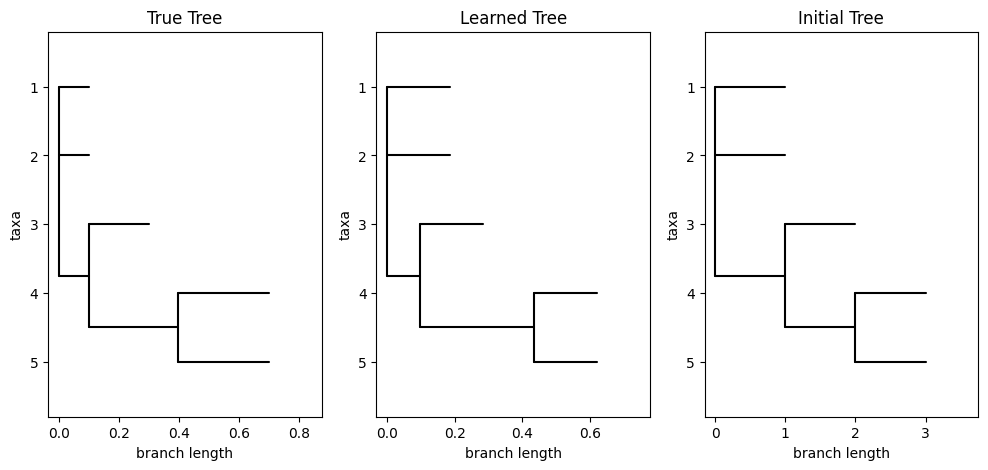

In [12]:
# draw and save as png
import matplotlib.pyplot as plt
%matplotlib inline

# Create figure with two subplots
figure, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 5))

# draw the true tree
tree.draw(axes=ax0, no_labels=True, do_show=False)
ax0.set_title("True Tree")

# draw the learned tree
learned_tree = tensortree.TreeHandler.copy(tree)
learned_tree.set_branch_lengths(B.numpy())
learned_tree.draw(axes=ax1, no_labels=True, do_show=False)
ax1.set_title("Learned Tree")

# draw the initial tree
initial_tree.draw(axes=ax2, no_labels=True, do_show=False)
ax2.set_title("Initial Tree")

figure.show()
